In [84]:
# Import necessary libraries
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
import glob


def get_measurement(file_dir):

    # Specify the directory containing the .fit files (replace with your actual path)
    file_paths = sorted(glob.glob(file_dir + "*.fit"))

    # Initialize lists to store combined data and time axis
    combined_data = []
    time_offset = 0  # To manage time axis across multiple files
    time_axes = []  # To concatenate time axes properly

    # Loop through each .fit file
    for file_path in file_paths:
        hdul = fits.open(file_path)
        
        # Access data (assuming it's a 2D array with shape [frequency, time])
        data = hdul[0].data
        
        # Extract time axis (dummy axis if not provided in the header)
        time_axis = np.arange(data.shape[1]) + time_offset
        time_axes.append(time_axis)
        
        # Append data to the combined list
        combined_data.append(data)
        
        # Update time offset for the next file
        time_offset += data.shape[1]
        
        # Close the file
        hdul.close()

    # Concatenate all data and time axes
    combined_data = np.hstack(combined_data)  # Combine along the time axis
    time_axis_combined = np.hstack(time_axes)  # Combined time axis
    freq_axis = np.arange(combined_data.shape[0])  # Dummy frequency axis

    return time_axis_combined, freq_axis, combined_data






In [85]:

import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

from scipy.signal import savgol_filter

def savgol_smooth(data, window_length=5, poly_order=2):
    """
    Smooths a 2D array along the first axis using the Savitzky-Golay filter.

    Parameters:
        data (ndarray): 2D array to be smoothed.
        window_length (int): Length of the filter window (must be odd).
        poly_order (int): Polynomial order to fit.

    Returns:
        ndarray: Smoothed 2D array.
    """
    smoothed_data = np.apply_along_axis(
        lambda x: savgol_filter(x, window_length=window_length, polyorder=poly_order),
        axis=0,
        arr=data
    )
    return smoothed_data



def gaussian(x, I, mu, sigma, A, B):
    return I * np.exp(-((x - mu) ** 2) / (2 * sigma ** 2)) + A*x + B


def theoretical_fit(x, S, V, omega, delta):
    return S*(1+V*np.sin(omega*x+delta))






In [86]:
def get_V_Bl_fromOneChannel(time, data, freq=0, measurement=0,guess=[1, 0.035, 0.0043, 5.6], printbool=False):
    try:
        if printbool:
            print(f"Measurement {measurement}, Channel {freq}")

        # Apply smoothing
        data = savgol_smooth(data, window_length=500, poly_order=3)

        # Fit the Gaussian function (using example Gaussian-like data)
        lower_bounds=[-np.inf,-np.inf,-np.inf,-0.0005, -np.inf]
        upper_bounds=[np.inf,np.inf,np.inf,0.0005, np.inf]
        gaussian_params, pcov = curve_fit(gaussian, time, data, p0=[17.5, 5720, 4640, 0, 140],bounds=(lower_bounds, upper_bounds))
        I, mu, sigma, A, B = gaussian_params
        err_gauss = np.sqrt(np.diag(pcov))
        t_min = int(max(np.rint(mu-abs(sigma)),0))
        t_max = int(min(np.rint(mu+abs(sigma)),len(time)-1))

        # Generate fitted values for plotting
        fitted_gaussian_linear = gaussian(time, I, mu, sigma, A, B)
        fitted_gaussian = gaussian(time, I, mu, sigma, 0, 0)
        linear = A*time + B

        if printbool:
            plt.plot(time, data, label="Data", color="green")
            plt.plot(time, fitted_gaussian_linear, label=f"Gaussian+linear fit: I={I:.2f}, μ={mu:.2f}, σ={sigma:.2f}, A={A:.5f}B={B:.2f}", color="purple")
            plt.title(f"Gaussian + Linear Fit; Measurement {measurement}, Channel {freq}")
            plt.xlabel("Time")
            plt.ylabel("Data")
            plt.legend()

            plt.tight_layout()
            plt.show()



        linear = A*time + B
        data = data - linear
        err_int = 0
        err_linfit = np.sqrt(err_int**2 + (time*err_gauss[3])**2 + err_gauss[4]**2)
        data = data/fitted_gaussian

        dI = np.exp(-(time-mu)**2/(2*sigma**2))
        dmu = I * np.exp(-(time-mu)**2/(2*sigma**2))* (-2*(time-mu)/(2*sigma**2))
        dsigma = I * np.exp(-(time-mu)**2/(2*sigma**2)) * (time - mu)**2/sigma**3
        err_gaussfit = np.sqrt((dI * err_gauss[0])**2 + (dmu * err_gauss[1])**2 + (dsigma * err_gauss[2])**2)
        err_division = data * np.sqrt((err_linfit/data)**2 + (err_gaussfit/fitted_gaussian)**2)
        

        fit_params, pcov = curve_fit(theoretical_fit, time[t_min:t_max], data[t_min:t_max], p0=guess)
        S, V, omega, delta = fit_params
        std_mat = np.sqrt(np.diag(pcov))

        


        #dS = 1+V*np.sin(omega*time+delta)
        #dV = S*np.sin(omega*time+delta)
        #domega = S*V*np.cos(omega*time+delta)*time
        #ddelta = S*V*np.cos(omega*time+delta)
        #err_theofit = np.sqrt(dS**2*std_mat[0]**2 + dV**2*std_mat[1]**2 + domega**2 *std_mat[2]**2 + ddelta**2 * std_mat[3]**2)

        if printbool:
            # Generate fitted values for plotting
            fitted = theoretical_fit(time, S, V, omega, delta)
            plt.scatter(time[t_min:t_max], data[t_min:t_max], label="(Data-Linear)/Gaussian", color="green")
            plt.plot(time[t_min:t_max], fitted[t_min:t_max], label=f"Fit S={S:.2f}, V={V:.2f}, omega={omega:.4f}, delta={delta:.2f}B={B:.2f}", color="purple")
    
            plt.title(f"Fit; Measurement {measurement}, Channel {freq}")
            plt.xlabel("Time")
            plt.ylabel("Data")
            plt.legend()

            plt.tight_layout()
            plt.show()

        #declination of the sun January 10th
        dec = np.cos(2*np.pi/360 *22.1)

        std = np.sum(np.sqrt(np.diag(pcov)))
        V_err = np.sqrt(np.diag(pcov))[1]
        omega_err = np.sqrt(np.diag(pcov))[2]
        Bl_err = omega_err /(2*np.pi)**2 * 24*60*60*4/dec
        
        
        #old: 0.02
        if (std < 0.02):
            print(f"accepted measurement {measurement}, channel {freq}")
  
            return abs(V), abs(omega/(2*np.pi)**2 * 24*60*60*4/dec), V_err, Bl_err
        
        else:
            print(f"not accepted measurement {measurement}, channel {freq}")
            return 0,0,0,0
        

    except Exception as e:
        # Log the exception for debugging purposes if needed
        print(f"Exception at measurement {measurement}, channel {freq}: {e}")
        return 0,0,0,0







In [87]:

# Directories for measurements
file_dirs = [
    "sun_meas_25/meas_1/", #good 
    "sun_meas_25/meas_2/", #good
    "sun_meas_25/meas_3/", #good
    #"sun_meas_25/meas_4/",#sunset
    #"sun_meas_25/meas_5/",#clouds
    "sun_meas_25/meas_6/", #good
    "sun_meas_25/meas_7/", #very early -> only to the left
    "sun_meas_25/meas_8/",
    "sun_meas_25/meas_9/"
]
guesses = [[1, 0.035, 0.0043, 5.6], 
           [1, 0.035, 0.0047, 5.6],
           [1, 0.035, 0.0046, 5.6],
           #[1, 0.035, 0.0043, 5.6],
           #[1, 0.035, 0.0043, 5.6],
           [1, 0.035, 0.0043, 5.6],
           [1, 0.035, 0.0043, 5.6],
           [1, 0.035, 0.0043, 5.6],
           [1, 0.035, 0.0055, 5.6]]

# Load measurements
measurements = [get_measurement(file_dir) for file_dir in file_dirs]
# Each element of measurements is (time, freq, data)


#test = 0
#test_freq = 50
#(time, freq, data) = measurements[test]
#v, b, verr, berr = get_V_Bl_fromOneChannel(time, data[test_freq], test_freq, test, guesses[test], printbool=True)


# Prepare storage for results
results = []
for file_index, (time, freq, data) in enumerate(measurements):
    visibilities = np.empty(len(freq), dtype=float)
    Bl = np.empty(len(freq), dtype=float)
    visibilities_err = np.empty(len(freq), dtype=float)
    Bl_err = np.empty(len(freq), dtype=float)

    for i, freq in enumerate(np.concatenate((np.arange(10,50),np.arange(150,180)))):
        visibilities[i], Bl[i], visibilities_err[i], Bl_err[i] = get_V_Bl_fromOneChannel(time, data[i], freq, file_index+1, guesses[file_index], printbool=False)

    results.append((visibilities, Bl, visibilities_err, Bl_err))





accepted measurement 1, channel 10
accepted measurement 1, channel 11
accepted measurement 1, channel 12
accepted measurement 1, channel 13
accepted measurement 1, channel 14
accepted measurement 1, channel 15
accepted measurement 1, channel 16
accepted measurement 1, channel 17
accepted measurement 1, channel 18
accepted measurement 1, channel 19
accepted measurement 1, channel 20
accepted measurement 1, channel 21
accepted measurement 1, channel 22
accepted measurement 1, channel 23
accepted measurement 1, channel 24
accepted measurement 1, channel 25
accepted measurement 1, channel 26
accepted measurement 1, channel 27
not accepted measurement 1, channel 28
accepted measurement 1, channel 29
not accepted measurement 1, channel 30
accepted measurement 1, channel 31
accepted measurement 1, channel 32
accepted measurement 1, channel 33
accepted measurement 1, channel 34
accepted measurement 1, channel 35
accepted measurement 1, channel 36
accepted measurement 1, channel 37
accepted mea

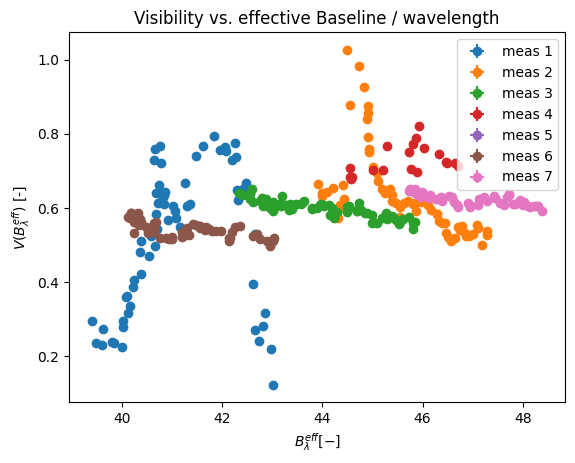

In [88]:
useful_B = []
useful_V = []
useful_B_err = []
useful_V_err = []

for index, (visibilities, Bl, visibilities_err, Bl_err) in enumerate(results):
    valid_indices =[(v, b, v_err, b_err) for v, b, v_err, b_err in zip(visibilities, Bl, visibilities_err, Bl_err) if not (abs(v) <1e-2 or abs(v)>2 or abs(b)>200 > 2 or abs(b)<5)]
    vs, bs, v_errs, b_errs = zip(*valid_indices) if valid_indices else ([],[],[],[])
    useful_B.append(bs)
    useful_V.append(vs)
    useful_B_err.append(b_errs)
    useful_V_err.append(v_errs)
    plt.errorbar(bs, vs, xerr=b_errs, yerr=v_errs,fmt='o', label=f"meas {index+1}")
plt.title("Visibility vs. effective Baseline / wavelength")
plt.ylabel("$V(B_{\lambda}^{eff})$ [-]")
plt.xlabel("$B_{\lambda}^{eff} [-]$")
plt.savefig("visibility_vs_effbase.png", dpi=150)
plt.legend()






0.01210750934060901
ratio 1.278926744906936


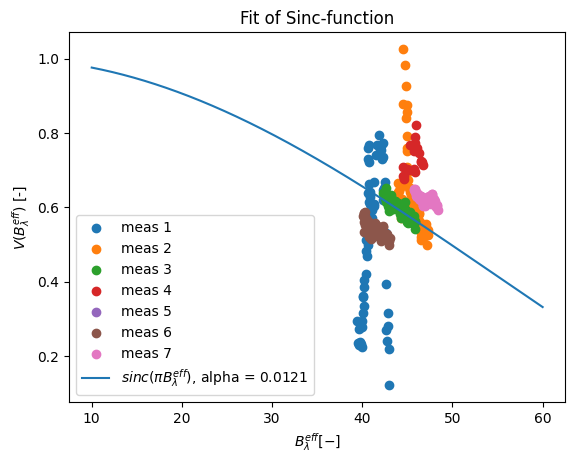

In [89]:
def sinc_func(Bl, alpha):
    return abs(np.sinc(Bl * alpha))
    
useful_B_array = np.concatenate(useful_B, axis=0 )
useful_V_array = np.concatenate(useful_V, axis=0 )

lower_bounds = 0.001  # Lower bounds for S and alpha
upper_bounds = 0.02      # Upper bounds for S and alpha


fit_params, pcov = curve_fit(sinc_func, useful_B_array, useful_V_array, p0=[0.004], bounds=(lower_bounds, upper_bounds))
alpha, = fit_params

B_fit = np.linspace(10,60, 1000)
fitted_sinc = sinc_func(B_fit, alpha)

print(alpha)
for i, (bs, vs) in enumerate(zip(useful_B, useful_V)):

    plt.scatter(bs, vs, label=f"meas {i+1}")

plt.plot(B_fit, fitted_sinc, label = f"$sinc(\pi B_{{\lambda}}^{{eff}})$, alpha = {alpha:.4f}")

plt.title("Fit of Sinc-function")
plt.ylabel("$V(B_{\lambda}^{eff})$ [-]")
plt.xlabel("$B_{\lambda}^{eff} [-]$")
plt.legend()
plt.savefig("fit.png",dpi=150)

sun_radius = 696340 #km
sun_distance = 147.11e6 #km

estimated_radius = alpha*sun_distance/2
print(f"ratio {estimated_radius/sun_radius}")

